### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
dataset_name = "darcy-flow"

x_LF, x_HF, normalization_vars, mask = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    return_mask=True,
    return_normalization_vars=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading Darcy flow data ...
x_LF.shape=(5621, 10201) x_HF.shape=(5621, 10201)


### Plot data 

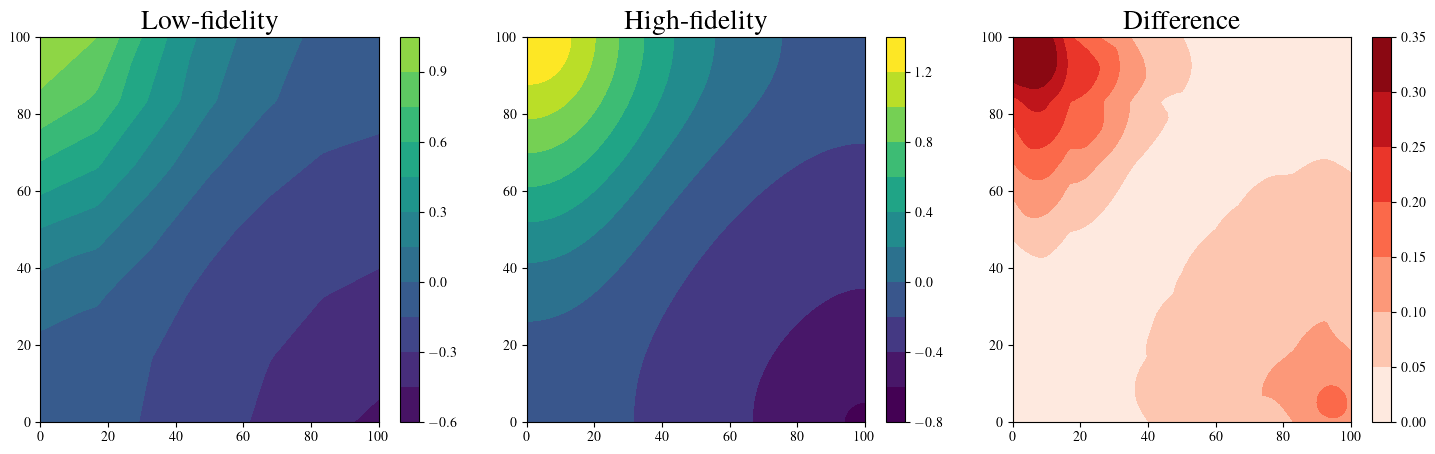

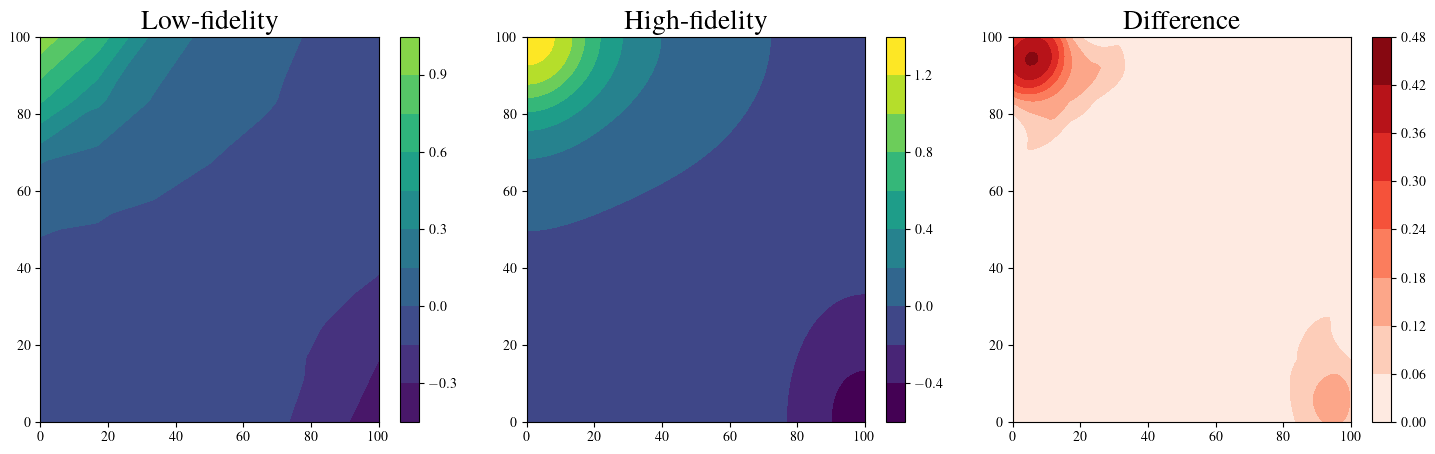

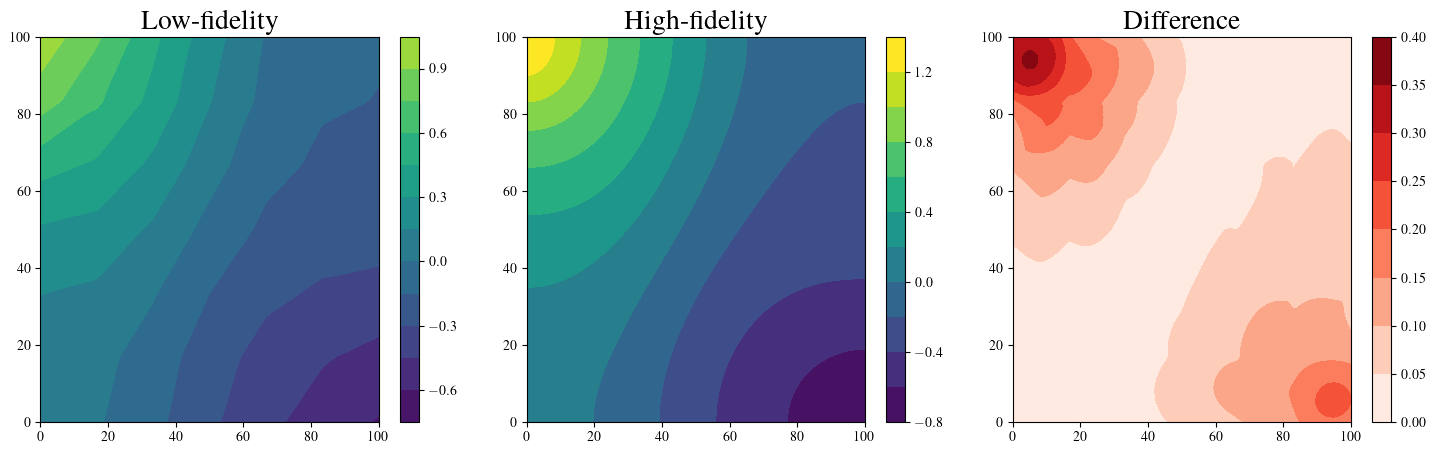

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'trunc',
    'spectrum_cutoff': 1200,
}
model = MultiFidelityModel(**model_config)

#### Perform spectral clustering

In [6]:
n_HF = 120
inds_train, labels = model.cluster(g_LF, n_HF)

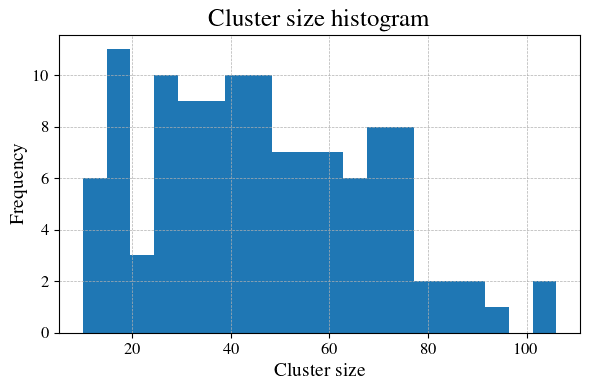

In [7]:
plot_cluster_size_hist(labels)

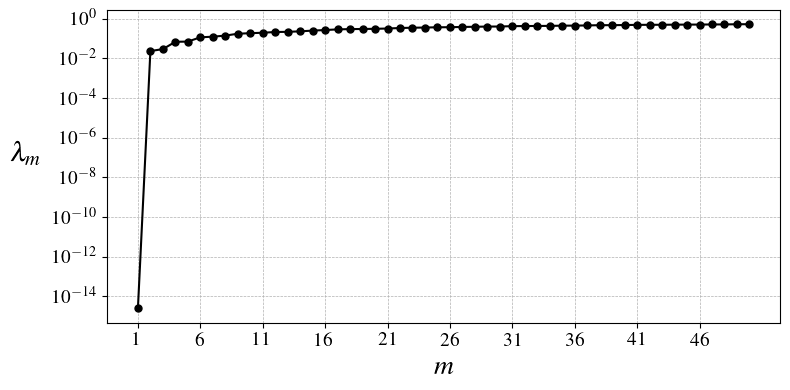

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
inds_val, inds_test = val_test_split(
    n_data=x_HF.shape[0], 
    inds_train=inds_train, 
    split_ratio=0.0075
)

x_HF_train = x_HF[inds_train, :]
x_HF_val = x_HF[inds_val, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_val.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(120, 10201) x_HF_val.shape=(41, 10201) x_HF_test.shape=(5460, 10201)


#### Hyper-parameters search

In [10]:
train = False

In [11]:
def cost_fn(kappa):
    """
    Custom cost function for the optimization.
    """
    # Create the model 
    model_config = {
        'sigma': 0.01,
        'method': 'full',
    }
    model = MultiFidelityModel(**model_config)

    model.kappa = kappa

    x_MF, _, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    x_LF = g_LF.nodes
    _, e_MF = error_analysis(
        x_LF[inds_val],
        x_MF[inds_val],
        x_HF_val,
        return_values=True,
        verbose=0,
    )
    return np.mean(e_MF), np.mean(dPhi)


def train_loop(kappas):
    """
    Train the model for a range of kappa values.
    """
    errors = []
    dPhis = []
    for kappa in kappas:
        error, dPhi = cost_fn(kappa)
        errors.append(error)
        dPhis.append(dPhi)
    return errors, dPhis

In [12]:
if train:

    # Loop thru kappas
    kappas = np.logspace(-12, 3, 50)
    errors, dPhis = train_loop(kappas)

    # Find the optimal kappa
    ind_opt = np.argmin(np.abs(np.array(dPhis) - 3 * model_config["sigma"]))
    kappa_opt = kappas[ind_opt]
    print(f"Optimal kappa = {kappa_opt}")

    # Plots
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the first set of data
    ax1.plot(kappas, errors , 'b-')
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\kappa$', fontsize=14)
    ax1.set_ylabel('error', color='b', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a twin axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the second set of data
    ax2.plot(kappas, dPhis, 'r-')
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\mathrm{mean}(\sqrt{C_{ii}})$', color='r', rotation=0, labelpad=50, fontsize=14)
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.plot([kappa_opt, kappa_opt], [3.5, 19.5], 'k--')
    ax2.grid('on')

    plt.title('Darcy flow data')

In [13]:
if not train:

    import yaml
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    with open(yaml_file_path, 'r') as file:
        MODEL_CONFIG = yaml.safe_load(file)

    kappa_opt = MODEL_CONFIG["darcy-flow"]["model_config"]["kappa"]
    print(f"Optimal kappa = {kappa_opt}")

Optimal kappa = 0.212


#### Train the model with optimized hyperprameters

In [14]:
best_config = {
    'kappa': kappa_opt,
}

model_config.update(best_config)
model = MultiFidelityModel(**model_config)

In [15]:
x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
model.summary()

Model Configuration:
sigma                  : 0.01
beta                   : 2
kappa                  : 0.212
omega                  : 395.83301764303235
method                 : trunc
spectrum_cutoff        : 1200
tau                    : 0.023142587895714176
n_clusters             : None
_is_graph_clustered    : False


Text(0.5, 1.0, 'Variance histogram for Darcy problem')

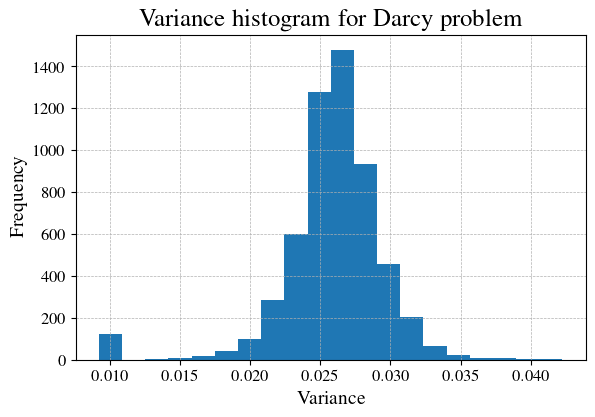

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram for Darcy problem", fontsize=18)

### Results

In [17]:
# Error Analysis for validation datadet
error_analysis(x_LF[inds_val], x_MF[inds_val], x_HF_val)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         24.92
Error MF:         4.44
Percentage drop:  82.2%


In [18]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         25.2
Error MF:         4.03
Percentage drop:  84.01%


In [19]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         25.2
Error MF:         3.96
Percentage drop:  84.3%


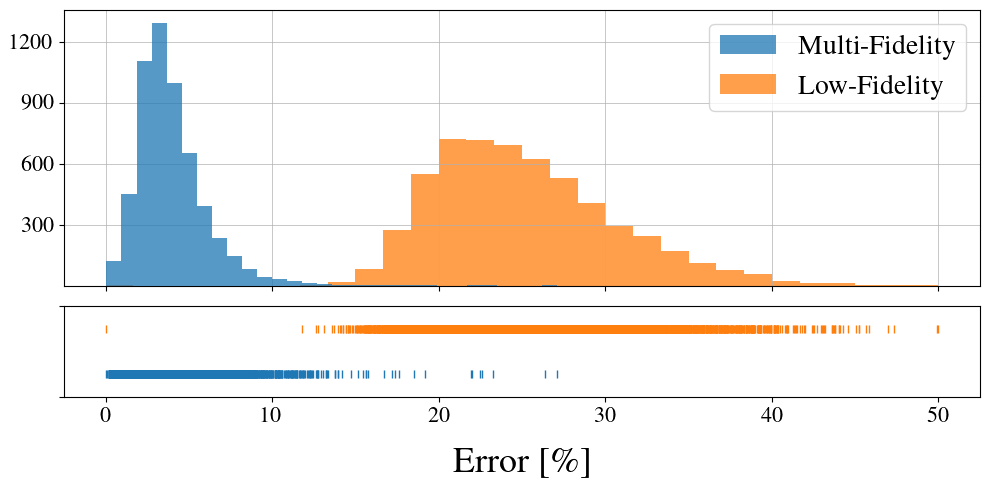

In [20]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=30, bins_MF=30, mask=None)

In [21]:
import os
data_path = "/Users/orazio/Desktop/codes/spectral-multifidelity/data/"
K = np.load(os.path.join(data_path, "darcy/K.npy"))
K = K[:, :, mask]

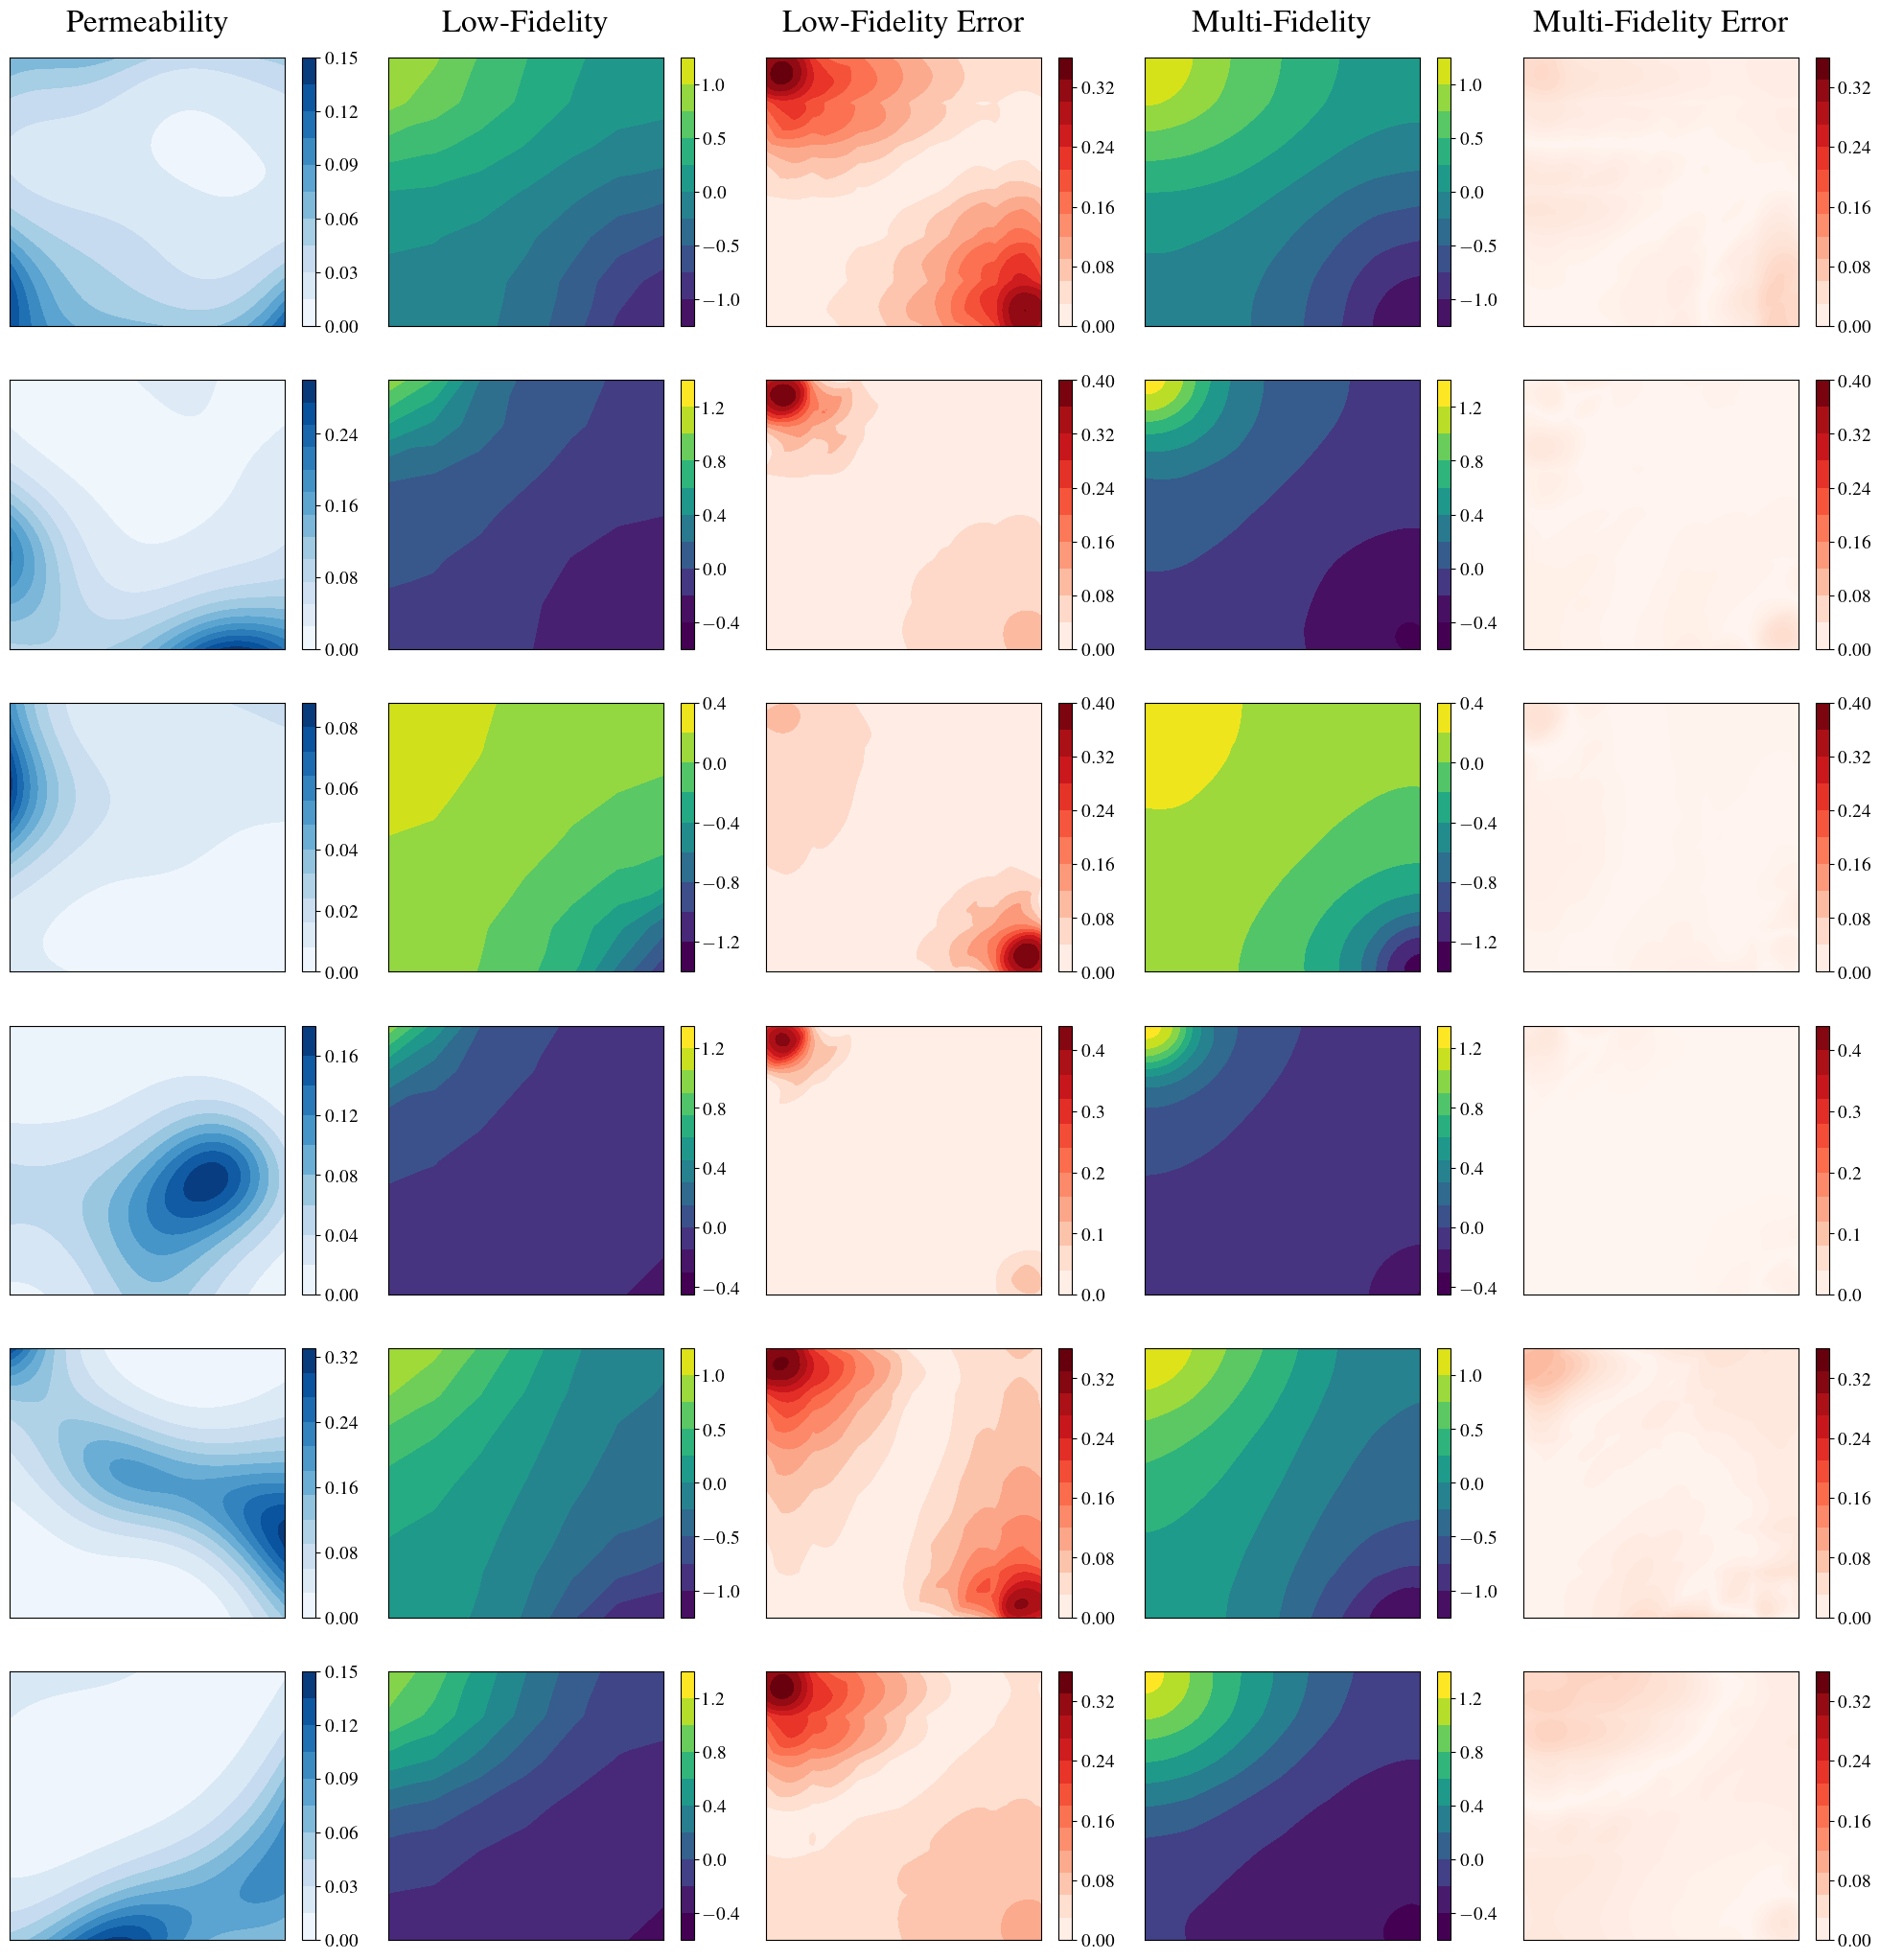

In [22]:
plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    samples=[4059, 5505, 1131, 3367, 11, 194],
    input_field=K,
)

### Explore UQ applications

In [18]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [19]:
g_MF = Graph(data=x_MF, **graph_config)

In [20]:
_, eigevs = g_MF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [ ]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.175,
    init='random', 
    random_state=42
).fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmin=0.015, vmax=0.035)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Darcy Flow data (Case 3)', fontsize=26, pad=10)